In [20]:
#Code from Fabio to import index data including applying comp matrix - JT mods added
import os
import sys
import numpy as np
import numpy.linalg
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import fcsparser

In [21]:
fn = '../Data/RN_BM/Indexed/Sample_INX_AS0055-CD34_004_015.fcs'
meta, data = fcsparser.parse(fn, reformat_meta=True)

i = 1
key = f'INDEX SORTING LOCATIONS_{i}'
sort_locs = []
while key in meta:
    sort_locs.append(meta[key])
    i += 1
    key = f'INDEX SORTING LOCATIONS_{i}'
sort_locs = ''.join(sort_locs).split(';')
wells = []
for loc in sort_locs:
    if loc == '':
        continue
    row_index, col = loc.split(',')
    row = chr(64 + int(row_index))
    well = row+col
    wells.append(well)   #Wells is a list of well locations with data derived from the index file

with open('../Results/metadata.txt', 'w') as f:
    f.write(str(meta))  #just writes the metadata to a file - for curiosity   

In [22]:
# Get antibodies
channel_idx = [int(x[2:-1]) for x in meta if x.startswith('$P') and x.endswith('S')]
channeld = {meta['_channel_names_'][i-1]: meta[f'$P{i}S'] for i in channel_idx}

data.index = pd.Index(wells, name='Sorted well') #Renames index with well name

In [23]:
# Load compensation
comp_fields = meta['SPILL'].split(',')
n = int(comp_fields[0])
channels = comp_fields[1: n+1]
matrix = np.asarray(comp_fields[n+1:]).astype(np.float64).reshape((n, n)) 
# TODO: perhaps transpose the matrix?
# matrix = matrix.T
spill_matrix = pd.DataFrame(
    matrix,
    index=channels,
    columns=channels,
)  #spill_matrix is the comp matrix

In [24]:
# Just plotting for fun
if False:
    # Reorder the dyes by wavelength
    wls = [int(x.split('/')[0][-3:]) for x in channels]
    idx = np.argsort(wls)
    spill_by_wls = spill_matrix.iloc[idx].T.iloc[idx].T

    fig, ax = plt.subplots()
    sns.heatmap(np.log10(1e-4 + spill_by_wls), ax=ax)
    fig.tight_layout()

    plt.ion(); plt.show()

if False:
    data_comp = data.copy()
    compensation = spill_matrix
    # TODO: Perhaps the inverse matrix?
    #compensation.values = numpy.linalg.inv(compensation.values)
    for channel in channels:
        data_comp[channel] *= compensation.loc[channel].values @ data_comp[channels].values.T

        data_plot = data_comp
else:
    data_plot = data


xy_plots = [
         ['B530/30-A', 'R660/20-A'],
]

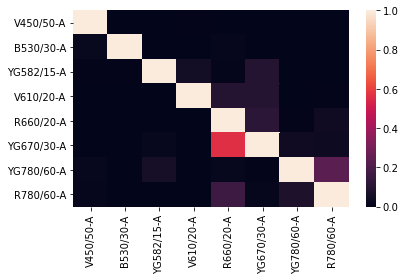

In [25]:
#Plots compensation matrix
# Reorder the dyes by wavelength
wls = [int(x.split('/')[0][-3:]) for x in channels]
idx = np.argsort(wls)
spill_by_wls = spill_matrix.iloc[idx].T.iloc[idx].T

fig, ax = plt.subplots()
sns.heatmap(spill_by_wls, ax=ax)
fig.tight_layout()

plt.ion(); plt.show()

In [26]:
#Apply comp and replace column names with antibodies
data_comp = data.copy()
compensation = spill_matrix
# TODO: Perhaps the inverse matrix?
#compensation.values = numpy.linalg.inv(compensation.values)
for channel in channels:
    data_comp[channel] *= compensation.loc[channel].values @ data_comp[channels].values.T #@ here is doing the matrix multiplication
data_comp.rename(columns = channeld, inplace = True)
data_comp

,FSC-A,FSC-W,FSC-H,SSC-A,SSC-W,SSC-H,CD34-PE,Lin-PE-Cy5,CD123-PE-Cy7,CD90-BV421,Zombie,CD45RA-FITC,IL1RAP-APC,CD38-APC-cy7,Time
Sorted well,,,,,,,,,,,,,,,
A2,107717.398438,89626.835938,78764.0,36948.031250,76736.687500,31555.0,3.713498e+05,1.299928e+06,1.002061e+07,6.407435e+04,2.444466e+08,1.027595e+08,6.628764e+07,2.658097e+10,762.799988
A3,118373.398438,91027.398438,85224.0,53741.640625,81184.164062,43383.0,8.179456e+05,6.725840e+06,5.472127e+07,1.198927e+05,2.481299e+09,4.143707e+09,4.938890e+08,1.599555e+11,1362.099976
A4,104888.695312,89684.859375,76646.0,32775.511719,77895.781250,27575.0,8.358252e+05,1.060476e+07,5.842118e+07,1.096947e+05,1.445932e+09,4.712443e+08,8.870385e+08,2.785113e+11,1624.199951
A5,100268.093750,89782.343750,73190.0,38817.660156,78560.750000,32382.0,9.767158e+05,4.722080e+06,3.180333e+07,2.431577e+05,8.509931e+08,2.376005e+09,1.094794e+08,1.589368e+10,2044.300049
A6,129972.593750,92179.906250,92405.0,51808.500000,80507.468750,42174.0,3.150510e+05,5.613730e+06,2.525997e+07,8.497106e+04,1.618134e+09,1.069541e+10,7.815144e+08,2.413755e+11,2448.699951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E22,102075.296875,89801.820312,74493.0,38112.960938,77931.140625,32051.0,1.078300e+06,4.879910e+05,6.568678e+06,5.734635e+05,1.089770e+08,4.135954e+07,1.370789e+07,3.104086e+08,97019.601562
F22,131025.593750,106709.257812,80470.0,93823.414062,94214.437500,65264.0,1.226628e+08,2.591594e+09,8.417771e+09,1.378668e+07,9.995146e+11,2.091590e+12,1.859687e+11,5.902212e+13,97529.796875
F21,129627.898438,94275.890625,90111.0,49185.449219,81607.570312,39499.0,2.301466e+05,2.100929e+05,9.331224e+06,1.070312e+05,1.100193e+08,1.067940e+08,3.730535e+05,1.526732e+09,98223.398438


(50000.0, 200000.0)

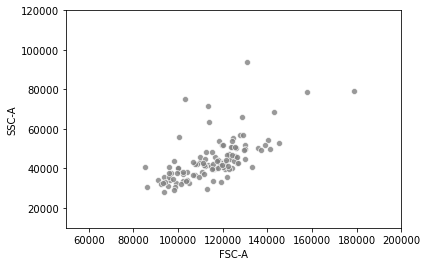

In [27]:
#Try plotting the data - linear plots for FSC and SSC
fig, ax = plt.subplots()
x = data_comp['FSC-A']
y = data_comp['SSC-A']

ax = sns.scatterplot(x,y,alpha=0.8, color='gray')
ax.set_ylim(10000, 120000)
ax.set_xlim(50000, 200000)

In [28]:
channeld

{'YG582/15-A': 'CD34-PE',
 'YG670/30-A': 'Lin-PE-Cy5',
 'YG780/60-A': 'CD123-PE-Cy7',
 'V450/50-A': 'CD90-BV421',
 'V610/20-A': 'Zombie',
 'B530/30-A': 'CD45RA-FITC',
 'R660/20-A': 'IL1RAP-APC',
 'R780/60-A': 'CD38-APC-cy7'}

In [29]:
data.rename(columns = channeld, inplace = True)

KeyError: 'Plate'

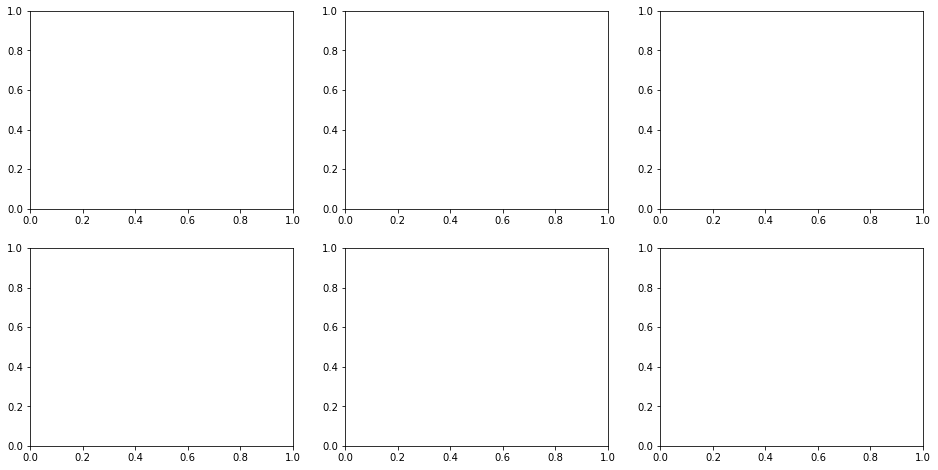

In [37]:
plot_list = [['FSC-A', 'SSC-A'], ['FSC-W', 'FSC-A'], ['SSC-H', 'SSC-A'], ['FSC-A','Lin-PE-Cy5'], ['CD34-PE', 'CD38-APC-cy7'], ['CD45RA-FITC', 'CD123-PE-Cy7']]
fix, axs = plt.subplots(2,3, figsize = (16,8))
axs = axs.ravel()



for ax,y in zip(axs, plot_list):
    x_label = y[0]
    y_label = y[1]
    ax.scatter(data[x_label] + 11, data[y_label] + 11, alpha = 0.5, c = data['Plate'], cmap = palette )
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if x_label in ['Lin-PE-Cy5', 'CD34-PE','CD38-APC-cy7', 'CD45RA-FITC','CD123-PE-Cy7']:
        ax.set_xscale('log')
        ax.set_xlim(left = 10)
    if y_label in ['Lin-PE-Cy5', 'CD34-PE','CD38-APC-cy7', 'CD45RA-FITC','CD123-PE-Cy7']:
        ax.set_yscale('log')
        ax.set_ylim(bottom = 10)
        
    ax.autoscale_view()  
        

In [31]:
data['CD34-PE'].median()

732.4800415039062

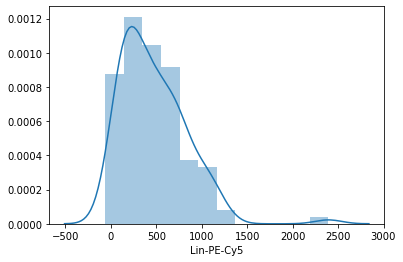

In [32]:
sns.distplot(data['Lin-PE-Cy5'])

(10000.0, 100000000.0)

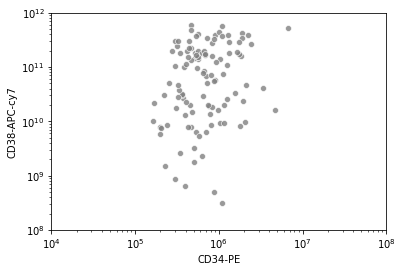

In [33]:
#Try plotting the data - linear plots for FSC and SSC
t = np.arange(0.1, 100000, 10)

fig, ax = plt.subplots()

x = data_comp['CD34-PE']
y = data_comp['CD38-APC-cy7']

ax = sns.scatterplot(x,y,alpha=0.8, color='gray')
ax.loglog()
ax.set_ylim(1e8, 1e12)
ax.set_xlim(1e4, 1e8)

In [13]:
channeld

{'YG582/15-A': 'CD34-PE',
 'YG670/30-A': 'Lin-PE-Cy5',
 'YG780/60-A': 'CD123-PE-Cy7',
 'V450/50-A': 'CD90-BV421',
 'V610/20-A': 'Zombie',
 'B530/30-A': 'CD45RA-FITC',
 'R660/20-A': 'IL1RAP-APC',
 'R780/60-A': 'CD38-APC-cy7'}

In [14]:
data

,FSC-A,FSC-W,FSC-H,SSC-A,SSC-W,SSC-H,YG582/15-A,YG670/30-A,YG780/60-A,V450/50-A,V610/20-A,B530/30-A,R660/20-A,R780/60-A,Time
Sorted well,,,,,,,,,,,,,,,
A2,107717.398438,89626.835938,78764.0,36948.031250,76736.687500,31555.0,561.350037,189.660004,304.110016,168.0,1526.0,160.080002,336.000000,2364.800049,762.799988
A3,118373.398438,91027.398438,85224.0,53741.640625,81184.164062,43383.0,808.780029,452.350006,542.820007,184.0,2987.0,637.710022,479.200012,1946.400024,1362.099976
A4,104888.695312,89684.859375,76646.0,32775.511719,77895.781250,27575.0,850.200012,685.610046,445.810028,171.0,1186.0,124.410004,591.200012,1926.400024,1624.199951
A5,100268.093750,89782.343750,73190.0,38817.660156,78560.750000,32382.0,934.130005,274.680023,335.720001,290.0,1512.0,1063.140015,157.600006,804.799988,2044.300049
A6,129972.593750,92179.906250,92405.0,51808.500000,80507.468750,42174.0,457.800018,815.320007,406.570007,212.0,2570.0,2523.000000,1015.200012,1925.599976,2448.699951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E22,102075.296875,89801.820312,74493.0,38112.960938,77931.140625,32051.0,997.350037,26.160000,95.920006,513.0,1526.0,138.330002,154.400009,116.000000,97019.601562
F22,131025.593750,106709.257812,80470.0,93823.414062,94214.437500,65264.0,10922.890625,1228.430054,312.830017,202.0,3578.0,799.530029,546.400024,1965.599976,97529.796875
F21,129627.898438,94275.890625,90111.0,49185.449219,81607.570312,39499.0,425.100006,51.230003,567.890015,266.0,2118.0,367.140015,5.600000,1989.599976,98223.398438


In [15]:
meta

{'__header__': {'FCS format': b'FCS3.1',
  'text start': 256,
  'text end': 4489,
  'data start': 4495,
  'data end': 11514,
  'analysis start': 0,
  'analysis end': 0},
 '$BEGINANALYSIS': '0',
 '$ENDANALYSIS': '0',
 '$BEGINSTEXT': '0',
 '$ENDSTEXT': '0',
 '$BEGINDATA': '4495',
 '$ENDDATA': '11514              ',
 '$FIL': 'Sample_INX_AS0055-CD34_004_015.fcs',
 '$SYS': 'Windows 7 6.1',
 '$TOT': 117,
 '$PAR': 15,
 '$MODE': 'L',
 '$BYTEORD': '4,3,2,1',
 '$DATATYPE': 'F',
 '$NEXTDATA': 0,
 'CREATOR': 'BD FACSDiva Software Version 8.0.1',
 'TUBE NAME': 'INX_AS0055-CD34_004',
 '$SRC': 'Sample',
 'EXPERIMENT NAME': 'AS20191018',
 'GUID': 'ef5f3c13-390d-4f18-bd43-bed0e9222625',
 '$DATE': '18-OCT-2019',
 '$BTIM': '16:10:54',
 '$ETIM': '16:10:54',
 'SETTINGS': 'Cytometer',
 'WINDOW EXTENSION': '0.00',
 'EXPORT USER NAME': 'annsch',
 'EXPORT TIME': '18-OCT-2019-16:20:00',
 'FSC ASF': '0.84',
 'AUTOBS': 'TRUE',
 '$INST': ' ',
 '$TIMESTEP': '0.01',
 'SPILL': '8,YG582/15-A,YG670/30-A,YG780/60-A,V450